In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3b
commitnumber = 5014a19
conc = None
dv = 0.001
klin = 1e-24
molecule = h2o
ng_adju = [0]
ng_refs = [6]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 294
vmax = 720
vmin = 620
w_diffuse = [(1.66, 1.66, 1.66, 1.55, 1.5, 1.66)]
wgt = [(0.8, 0.8, 0.8, 0.6, 0.6, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

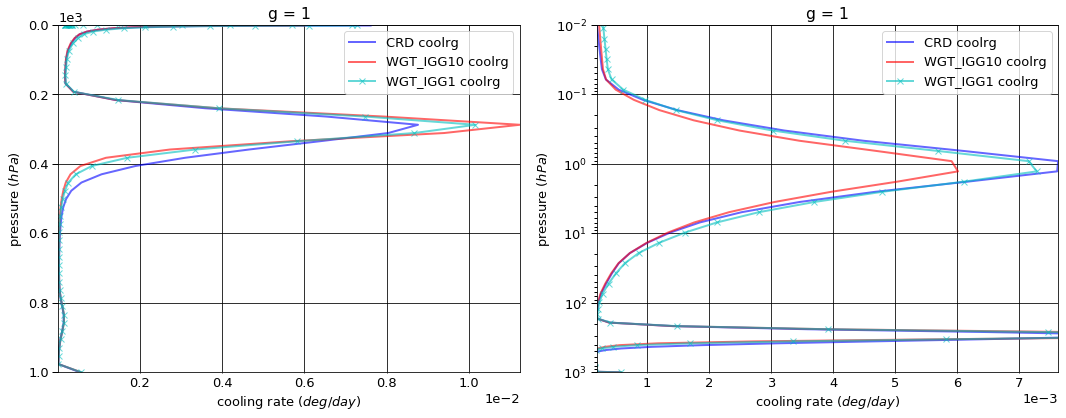

# Figure: cooling rate g-group 2

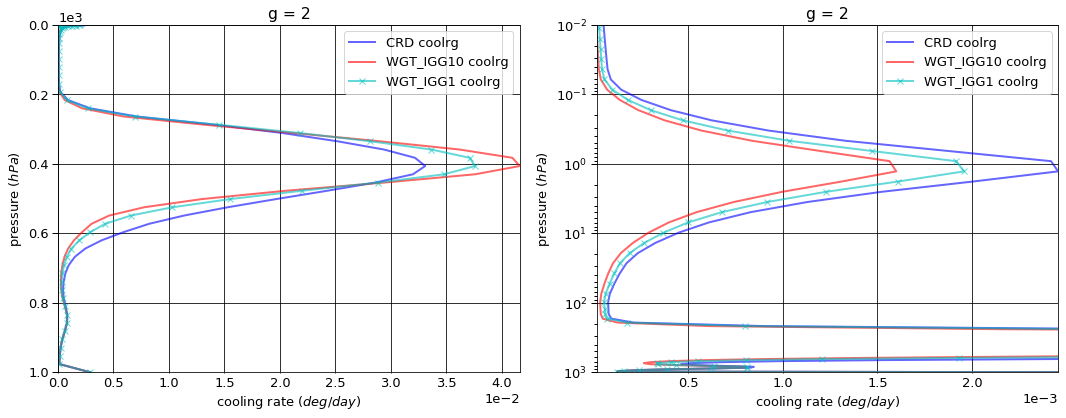

# Figure: cooling rate g-group 3

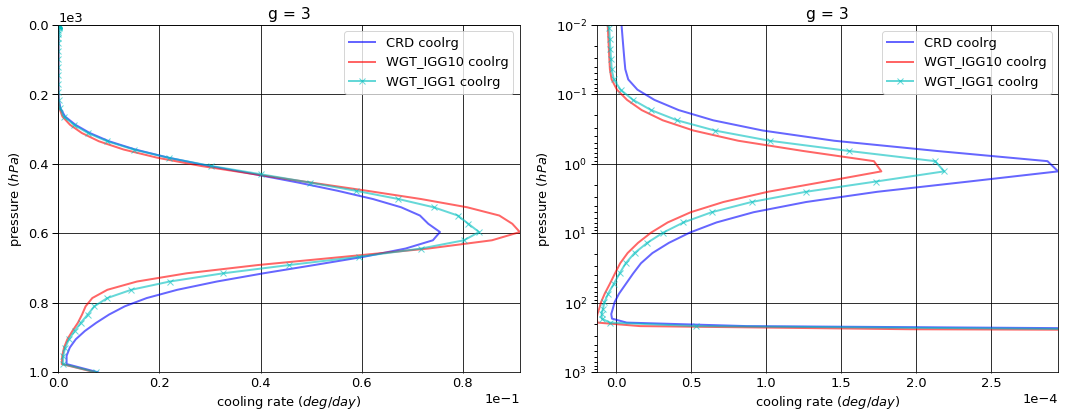

# Figure: cooling rate g-group 4

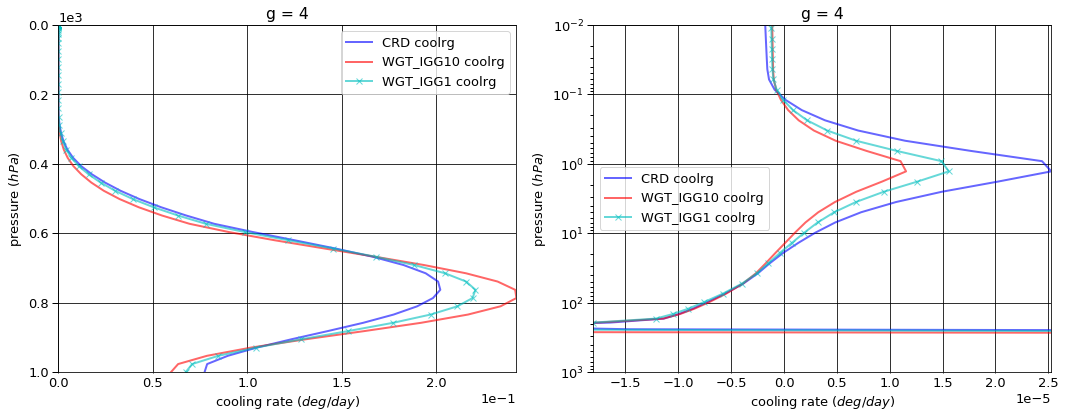

# Figure: cooling rate g-group 5

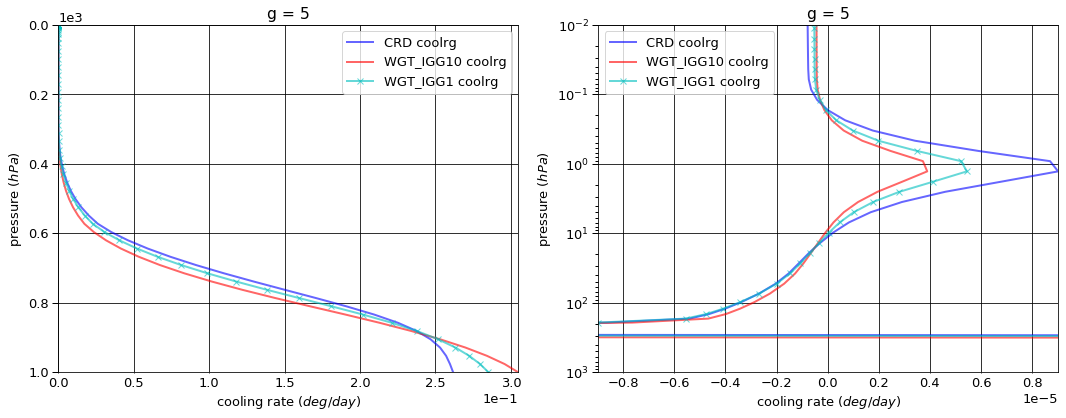

# Figure: cooling rate g-group 6

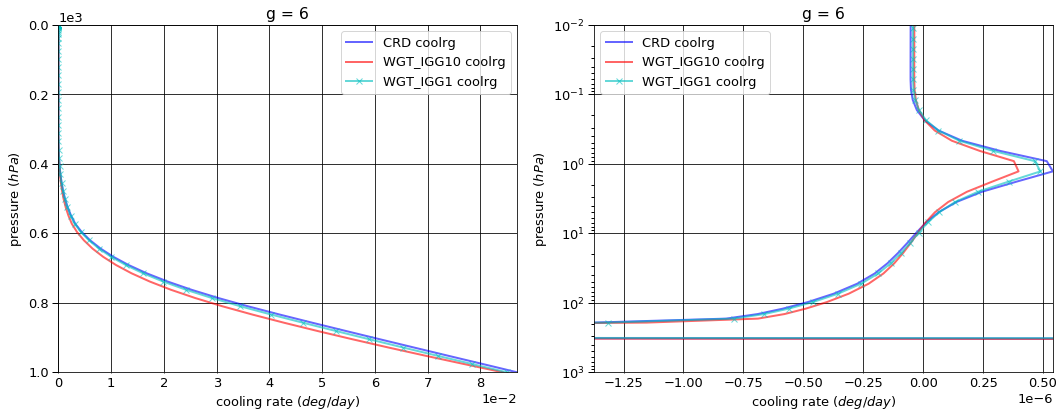

# Figure: cooling rate g-group total

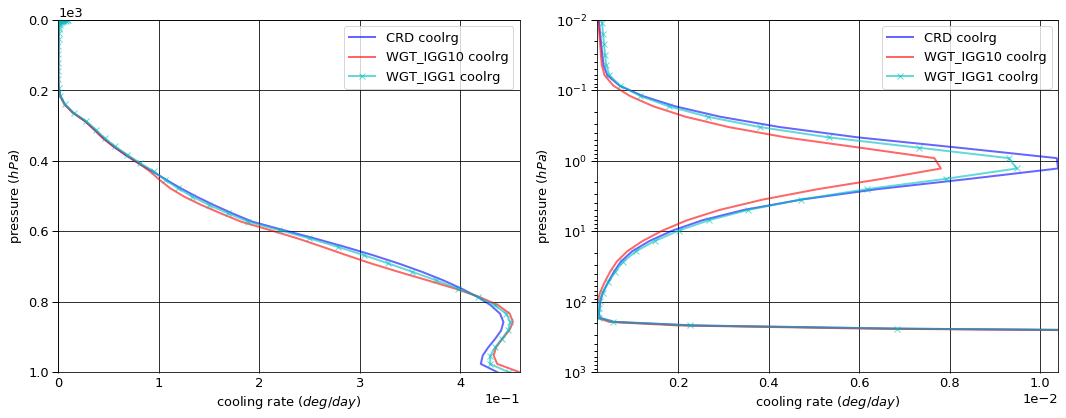

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.149462   0.000000  -0.149462
  1013.0   76     -0.331531   0.330000  -0.001530
2 0.0      1      -0.937094   0.000000  -0.937094
  1013.0   76     -1.699490   1.691484  -0.008007
3 0.0      1      -2.838504   0.000000  -2.838504
  1013.0   76     -4.099336   4.076039  -0.023297
4 0.0      1      -9.070929   0.000000  -9.070929
  1013.0   76    -10.914928  10.338190  -0.576738
5 0.0      1     -16.041241   0.000000 -16.041241
  1013.0   76    -17.103426   9.800054  -7.303372
6 0.0      1      -9.627230   0.000000  -9.627230
  1013.0   76     -9.816126   2.149520  -7.666606


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.143614   0.000000  -0.143614
  1013.0   76     -0.337023   0.335424  -0.001599
2 0.0      1      -0.912996   0.000000  -0.912996
  1013.0   76     -1.707642   1.699540  -0.008102
3 0.0      1      -2.802903   0.000000  -2.802903
  1013.0   76     -4.119845   4.099640  -0.020205
4 0.0      1      -9.139705   0.000000  -9.139705
  1013.0   76    -10.959414  10.686280  -0.273134
5 0.0      1     -16.273969   0.000000 -16.273969
  1013.0   76    -17.151177   9.156133  -7.995044
6 0.0      1      -9.530846   0.000000  -9.530846
  1013.0   76     -9.689736   1.933216  -7.756520


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.144274   0.000000  -0.144274
  1013.0   76     -0.337023   0.335424  -0.001599
2 0.0      1      -0.915995   0.000000  -0.915995
  1013.0   76     -1.707642   1.699540  -0.008102
3 0.0      1      -2.807895   0.000000  -2.807895
  1013.0   76     -4.119845   4.098878  -0.020967
4 0.0      1      -9.086080   0.000000  -9.086080
  1013.0   76    -10.959414  10.606761  -0.352653
5 0.0      1     -16.149784   0.000000 -16.149784
  1013.0   76    -17.151177   9.622418  -7.528759
6 0.0      1      -9.511382   0.000000  -9.511382
  1013.0   76     -9.689736   2.075739  -7.613997


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.005848  0.000000  0.005848
  1013.0   76    -0.005492  0.005423 -0.000069
2 0.0      1      0.024098  0.000000  0.024098
  1013.0   76    -0.008152  0.008056 -0.000095
3 0.0      1      0.035601  0.000000  0.035601
  1013.0   76    -0.020509  0.023601  0.003092
4 0.0      1     -0.068775  0.000000 -0.068775
  1013.0   76    -0.044486  0.348090  0.303605
5 0.0      1     -0.232728  0.000000 -0.232728
  1013.0   76    -0.047751 -0.643921 -0.691672
6 0.0      1      0.096384  0.000000  0.096384
  1013.0   76     0.126390 -0.216304 -0.089914


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.005188  0.000000  0.005188
  1013.0   76    -0.005492  0.005423 -0.000069
2 0.0      1      0.021099  0.000000  0.021099
  1013.0   76    -0.008152  0.008056 -0.000095
3 0.0      1      0.030609  0.000000  0.030609
  1013.0   76    -0.020509  0.022839  0.002330
4 0.0      1     -0.015151  0.000000 -0.015151
  1013.0   76    -0.044486  0.268571  0.224086
5 0.0      1     -0.108543  0.000000 -0.108543
  1013.0   76    -0.047751 -0.177636 -0.225387
6 0.0      1      0.115847  0.000000  0.115847
  1013.0   76     0.126390 -0.073781  0.052609

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      6.849484e-05
  1001.112500 75     5.532943e-04
2 0.000312    1      2.170802e-05
  1001.112500 75     2.893653e-03
3 0.000312    1     -2.620179e-07
  1001.112500 75     7.844902e-03
4 0.000312    1     -2.065522e-06
  1001.112500 75     7.730355e-02
5 0.000312    1     -8.017603e-07
  1001.112500 75     2.617217e-01
6 0.000312    1     -5.062637e-08
  1001.112500 75     8.696100e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.320329e-04
  1001.112500 75     5.778743e-04
2 0.000312    1     -3.190477e-06
  1001.112500 75     2.928001e-03
3 0.000312    1     -7.770037e-06
  1001.112500 75     7.283277e-03
4 0.000312    1     -1.228938e-06
  1001.112500 75     5.947821e-02
5 0.000312    1     -4.359439e-07
  1001.112500 75     3.048886e-01
6 0.000312    1     -3.583233e-08
  1001.112500 75     8.423364e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.747146e-04
  1001.112500 75     5.778743e-04
2 0.000312    1      5.474714e-06
  1001.112500 75     2.928001e-03
3 0.000312    1     -7.490571e-06
  1001.112500 75     7.467626e-03
4 0.000312    1     -1.373204e-06
  1001.112500 75     6.729627e-02
5 0.000312    1     -5.291272e-07
  1001.112500 75     2.851766e-01
6 0.000312    1     -4.135607e-08
  1001.112500 75     8.501042e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      6.353807e-05
  1001.112500 75     2.457998e-05
2 0.000312    1     -2.489849e-05
  1001.112500 75     3.434730e-05
3 0.000312    1     -7.508019e-06
  1001.112500 75    -5.616253e-04
4 0.000312    1      8.365839e-07
  1001.112500 75    -1.782534e-02
5 0.000312    1      3.658163e-07
  1001.112500 75     4.316690e-02
6 0.000312    1      1.479404e-08
  1001.112500 75    -2.727359e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.062197e-04
  1001.112500 75     2.457998e-05
2 0.000312    1     -1.623330e-05
  1001.112500 75     3.434720e-05
3 0.000312    1     -7.228553e-06
  1001.112500 75    -3.772759e-04
4 0.000312    1      6.923180e-07
  1001.112500 75    -1.000728e-02
5 0.000312    1      2.726331e-07
  1001.112500 75     2.345488e-02
6 0.000312    1      9.270293e-09
  1001.112500 75    -1.950580e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.664460,0.000000,-38.66446
1013.0,76,-43.964837,28.385288,-15.57955



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.804033,0.000000,-38.804033
1013.0,76,-43.964838,27.910233,-16.054604



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.615411,0.00000,-38.615411
1013.0,76,-43.964838,28.43876,-15.526077



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.395724e-01,0.000000,-0.139572
1013.0,76,-3.400000e-07,-0.475054,-0.475054



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,4.904885e-02,0.000000,0.049049
1013.0,76,-3.400000e-07,0.053473,0.053473


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000087
1001.112500,75,0.437278



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000119
1001.112500,75,0.459390



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000171
1001.112500,75,0.448457



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000032
1001.112500,75,0.022112



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000084
1001.112500,75,0.011179


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00745,0.007666
2,0.03852,0.038841
3,0.09291,0.093708
4,0.24753,0.249277
5,0.38811,0.390111
6,0.22548,0.220397


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.620800e-21
2,2.554449e-22
3,4.025919e-23
4,6.345018e-24
5,1.000002e-24
6,1.306671e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.620800e-21,NaN,0.00745,0.007666,0.00745,0.007666,600.0
2,2.554449e-22,0.157604,0.03852,0.038841,0.04597,0.046507,600.0
3,4.025919e-23,0.157604,0.09291,0.093708,0.13888,0.140215,600.0
4,6.345018e-24,0.157604,0.24753,0.249277,0.38641,0.389491,600.0
5,1.000002e-24,0.157604,0.38811,0.390111,0.77452,0.779603,600.0
6,1.306671e-25,0.130667,0.22548,0.220397,1.00000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
